In [149]:
import torch
import torch.nn as nn

from torch import optim
import torchvision.datasets as dataset
import torchvision.transforms as transforms
import torch.utils.data

import pandas as pd

from utils.tokenMaker import LangV2 as Lang
from utils.tool import padding, flatMutileLength, fixString
from model.BigModel import SubImgToSeq, SubVideoToSeq
from dataset.readVideo import DramaDataset
useCuda = True
device = torch.device("cuda" if useCuda else "cpu")

In [160]:
DataDir="/home/ball/Videos/Broke"
datasets = DramaDataset(basedir=DataDir,
                        maxFrame=1,
                        timeOffset=0.2,
                        startSeries=1,
                        maxSeries=5,
                        pairTime=1,
                        useBmp=False,
                        randomStart=False)
transform = transforms.Compose([transforms.Resize(256),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                ])
len(datasets)

Total Drama: 113


42690

In [151]:
import random
def getSample(size):
    imgs = []
    pres = []
    nexs = []
    for i in range(size):
        pre, nex, img = random.choice(datasets)
        imgs.append(img)
        pres.append(pre)
        nexs.append(nex)
    return pres, nexs, imgs

In [152]:
def predit(model, lang, imgs, subtitle, max_length=50):
    ans = []
    probs = []
    inputImgs = imgs.unsqueeze(0).to(device)
    subtitle = torch.LongTensor(lang.sentenceToVector(subtitle, sos=False, eos=False)).unsqueeze(0).to(device)
    inputs = torch.LongTensor([[lang["SOS"]]]).long().to(device)
    
    hidden = None
    
    cxt = model.makeContext(inputImgs, subtitle)
    for i in range(max_length):
        outputs, hidden = model.decode(inputs, cxt, hidden)
        prob, outputs = outputs.topk(1)
        probs.append(prob.item())

        if(outputs.item() == lang["EOS"]):
            break
        ans.append(outputs.item())

        inputs = outputs.squeeze(1).detach()
    return lang.vectorToSentence(ans), probs

def mutilePredit(pres, nexs, imgs):
    makes = []
    for pre, nex, img in zip(pres, nexs, imgs):
        mk = predit(model, lang, transform(img[0]).unsqueeze(0), pre)
        makes.append(mk[0])
    return makes

def toBatchFirst(outputs):
    nep = len(outputs)
    nbatch = len(outputs[0])
    bFirst = []
    for b in range(nbatch):
        bdatas = []
        for e in range(nep):
            bdatas.append(outputs[e][b])
        bFirst.append(bdatas)
    return bFirst

In [153]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
toPIL = transforms.ToPILImage()

def showImgs(imgs, preSubs, targets, labels):
    col=1
    plt.figure(figsize=(20,50))
    for i in range(len(imgs)):
        plt.subplot(len(imgs)/col+1,col,i+1)
        plt.axis('off')
        plt.imshow(imgs[i])
        plt.title("Pre: {}\nNext: {}\nPredit: {}".format(preSubs[i], targets[i], labels[i]), fontsize=20)
    plt.show()
def showVar(data):
    x = range(0, data.size(-1))
    plt.bar(x, data.data.cpu())
    plt.show()
def showValue(data):
    x = range(0, len(data))
    plt.plot(x, data)
    plt.show()

In [166]:
import pickle
import os
ModelDir = "ImgSub2Sub/models/BK_CH_JIEBA_200"
# ModelDir = "ImgSub2Sub/models.old/bken_fix_150"
with open(os.path.join(ModelDir, "Lang.pkl"), 'rb') as f:
    lang = pickle.load(f)
    print("Load lang model: {}. Word size: {}".format(ModelDir, len(lang)))
model = torch.load(os.path.join(ModelDir, "SubImgModel.20.pth")).to(device).eval()

Load lang model: ImgSub2Sub/models/BK_CH_JIEBA_200. Word size: 36841


In [143]:
pres, nexs, imgs = getSample(6)

In [147]:
ppres, pnexs, pimgs = pres, nexs, imgs
# ppres = [ppres[4]]*len(ppres)
# pimgs = [pimgs[5]]*len(pimgs)
makes = mutilePredit(ppres, pnexs, pimgs)

In [ ]:
showImgs([ims[0] for ims in pimgs], ppres, pnexs, makes)

In [14]:
import pandas as pd
result = pd.DataFrame([], columns=["pre", "next", "make"])
for _ in range(10):
    pres, nexs, imgs = getSample(64)
    makes = mutilePredit(pres, nexs, imgs)
    parts = pd.DataFrame([], columns=["pre", "next"])
    parts["pre"] = pres
    parts["next"] = nexs
    parts["make"] = makes
    result = result.append(parts,ignore_index=True)

In [155]:
def getEncoder(modal, sub):
    subVar =  torch.LongTensor(lang.sentenceToVector(sub, sos=False, eos=False)).to(device).unsqueeze(0)
    return modal.subRnn(subVar)[0][:,-1,:]
cos = nn.CosineSimilarity(dim=1)

In [161]:
pres, nexs, imgs = getSample(64)

In [167]:
epcoss = []
outputs = []
result = pd.DataFrame([], columns=["pre", "next", "make"])
for i in range(1, 41):
    model = torch.load(os.path.join(ModelDir, "SubImgModel.{}.pth".format(i))).eval()
    makes = mutilePredit(pres, nexs, imgs)
    tars = torch.cat([getEncoder(model, nex) for nex in nexs], dim=0)
    preds = torch.cat([getEncoder(model, pred) for pred in makes], dim=0)
    cs = cos(tars, preds)
    epcoss.append(cs.mean().item())
    outputs.append(makes)
    
    parts = pd.DataFrame([], columns=["pre", "next"])
    parts["pre"] = pres
    parts["next"] = nexs
    parts["make"] = makes
    parts["epoch"] = i
    result = result.append(parts,ignore_index=True)
    print("Mean: {:.4f}, Max: {:.4f}, Min: {:.4f}".format(cs.mean().item(),
                                             cs.max().item(),
                                             cs.min().item()))
bfOutputs = toBatchFirst(outputs)

Mean: 0.0924, Max: 0.5162, Min: -0.1660
Mean: 0.0900, Max: 0.5279, Min: -0.1588
Mean: 0.1371, Max: 1.0000, Min: -0.1634
Mean: 0.1541, Max: 1.0000, Min: -0.1779
Mean: 0.1659, Max: 1.0000, Min: -0.2301
Mean: 0.2645, Max: 1.0000, Min: -0.1010
Mean: 0.3655, Max: 1.0000, Min: -0.1589
Mean: 0.4816, Max: 1.0000, Min: -0.1784
Mean: 0.6513, Max: 1.0000, Min: -0.0772
Mean: 0.7751, Max: 1.0000, Min: -0.1677
Mean: 0.8275, Max: 1.0000, Min: -0.0010
Mean: 0.8871, Max: 1.0000, Min: -0.0671
Mean: 0.9581, Max: 1.0000, Min: -0.0567
Mean: 0.9832, Max: 1.0000, Min: -0.0589
Mean: 0.9982, Max: 1.0000, Min: 0.8876
Mean: 1.0000, Max: 1.0000, Min: 1.0000
Mean: 1.0000, Max: 1.0000, Min: 1.0000
Mean: 1.0000, Max: 1.0000, Min: 1.0000
Mean: 1.0000, Max: 1.0000, Min: 1.0000
Mean: 0.9870, Max: 1.0000, Min: 0.1709


FileNotFoundError: [Errno 2] No such file or directory: 'ImgSub2Sub/models/BK_CH_JIEBA_200/SubImgModel.21.pth'

In [168]:
result["epoch"] = result["epoch"] * 2

In [169]:
result.to_json("others/result_bk_jieba_ins.json")

In [170]:
coss = []
for makes in outputs:
    tars = torch.cat([getEncoder(model, nex) for nex in nexs], dim=0)
    preds = torch.cat([getEncoder(model, pred) for pred in makes], dim=0)
    cs = cos(tars, preds)
    coss.append(cs.mean().item())
    print("Mean: {:.4f}, Max: {:.4f}, Min: {:.4f}, Equal: {}".format(cs.mean().item(),
                                                         cs.max().item(),
                                                         cs.min().item(),
                                                         (cs>=0.9).float().sum().item()))

Mean: 0.0399, Max: 0.4585, Min: -0.1343, Equal: 0.0
Mean: 0.0570, Max: 0.4281, Min: -0.1377, Equal: 0.0
Mean: 0.1110, Max: 1.0000, Min: -0.0760, Equal: 1.0
Mean: 0.1248, Max: 1.0000, Min: -0.0823, Equal: 1.0
Mean: 0.1473, Max: 1.0000, Min: -0.1623, Equal: 2.0
Mean: 0.2502, Max: 1.0000, Min: -0.1278, Equal: 8.0
Mean: 0.3500, Max: 1.0000, Min: -0.1506, Equal: 16.0
Mean: 0.4703, Max: 1.0000, Min: -0.1623, Equal: 23.0
Mean: 0.6425, Max: 1.0000, Min: -0.0596, Equal: 37.0
Mean: 0.7696, Max: 1.0000, Min: -0.1223, Equal: 45.0
Mean: 0.8211, Max: 1.0000, Min: -0.0309, Equal: 51.0
Mean: 0.8863, Max: 1.0000, Min: -0.0638, Equal: 55.0
Mean: 0.9580, Max: 1.0000, Min: -0.0638, Equal: 61.0
Mean: 0.9837, Max: 1.0000, Min: -0.0312, Equal: 63.0
Mean: 0.9980, Max: 1.0000, Min: 0.8723, Equal: 63.0
Mean: 1.0000, Max: 1.0000, Min: 1.0000, Equal: 64.0
Mean: 1.0000, Max: 1.0000, Min: 1.0000, Equal: 64.0
Mean: 1.0000, Max: 1.0000, Min: 1.0000, Equal: 64.0
Mean: 1.0000, Max: 1.0000, Min: 1.0000, Equal: 64.0
Mean

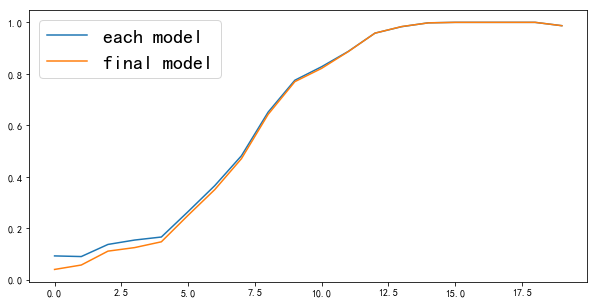

In [171]:
x = range(0, len(coss))
plt.figure(figsize=(10,5))
plt.plot(x, epcoss, label="each model")
plt.plot(x, coss, label="final model")

plt.legend(fontsize=20)
plt.show()

In [ ]:
i = 25
print("Pre: {}".format(pres[i]))
print("Next: {}\n".format(nexs[i]))
print("\n".join(bfOutputs[i]))
plt.axis('off')
plt.imshow(imgs[i][0])
plt.show()

In [34]:
result[result["epoch"]==40]

,epoch,make,next,pre
1216,40.0,抱歉 我不知道 這裏是正統猶太教社區,抱歉 我不知道 這裏是正統猶太教社區,兩位需要點什麼 除了長短更合適的裙子
1217,40.0,她們都認識我,她們都認識我,不信可以問問蘭蔻的柜姐
1218,40.0,一個塞滿漢堡肉的避孕套,一個塞滿漢堡肉的避孕套,就在這街上了
1219,40.0,我要和Michael結婚啦 就這位,我要和Michael結婚啦 就這位,我是Steve 我覺得單身派對 用紙杯蛋糕做甜點應該不錯
1220,40.0,這部分是我的地盤,這部分是我的地盤,她那個 同伴 指的不是情侶的那種
1221,40.0,現在我只用頂級的酒,現在我只用頂級的酒,是啊 我整個下午都在免費喝酒
1222,40.0,自打我見到你 我就說你應該找個,自打我見到你 我就說你應該找個,哦 真有你的 Caroline
1223,40.0,被困在查寧的身材里的丹澤爾嗎,被困在查寧的身材里的丹澤爾嗎,你簡直就像 啥
1224,40.0,去吧,去吧,即使那意味著你要搬出去住了
1225,40.0,那輛嬉皮士手工奶酪車雙宿雙棲,那輛嬉皮士手工奶酪車雙宿雙棲,跟你從布魯克林大橋推下去的


In [30]:
result

,epoch,make,next,pre
0,1.0,我知道 你是個天才,抱歉 我不知道 這裏是正統猶太教社區,兩位需要點什麼 除了長短更合適的裙子
1,1.0,我的人生 我是個 但我的名字,她們都認識我,不信可以問問蘭蔻的柜姐
2,1.0,我的人生中 我的人生中,一個塞滿漢堡肉的避孕套,就在這街上了
3,1.0,我們要去買咖啡機,我要和Michael結婚啦 就這位,我是Steve 我覺得單身派對 用紙杯蛋糕做甜點應該不錯
4,1.0,我們的生意是 但我的名字,這部分是我的地盤,她那個 同伴 指的不是情侶的那種
5,1.0,我的人生中 我的人生中,現在我只用頂級的酒,是啊 我整個下午都在免費喝酒
6,1.0,我是說 你是我的,自打我見到你 我就說你應該找個,哦 真有你的 Caroline
7,1.0,我的人生中的是 但我的名字是我的,被困在查寧的身材里的丹澤爾嗎,你簡直就像 啥
8,1.0,我的人生中 你是個人,去吧,即使那意味著你要搬出去住了
9,1.0,我的確是是個天才,那輛嬉皮士手工奶酪車雙宿雙棲,跟你從布魯克林大橋推下去的
